In [44]:
import os
import pandas as pd
import cv2
from detector import get_users, detect_hands, blur_person
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib
import mediapipe as mp
%matplotlib inline
from motrackers import CentroidTracker

from matplotlib.lines import Line2D
from ipywidgets import IntProgress
from IPython.display import display

from sequence import fill_holes, get_timeseries_prob, get_events
from ultralytics import YOLO

In [34]:
model_folder = 'results/models/model_big_with_hand'
hand_model = tf.saved_model.load(model_folder)

model = YOLO('yolov5su.pt')

In [3]:
videos = [f for f in os.listdir('VIDEOS/') if f.endswith('.avi')]

In [30]:
videos_imgs = {}

for v_name in videos:

    cap = cv2.VideoCapture('VIDEOS/'+v_name)
    images = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            break
        #frame = cv2.flip(frame, 1) # Mirror image
        images.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        if len(images)>300:
            break
        
    cap.release()
    videos_imgs[v_name[:-4]] = images

In [68]:
mp_face_detection = mp.solutions.face_detection
face_detection =  mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.2)

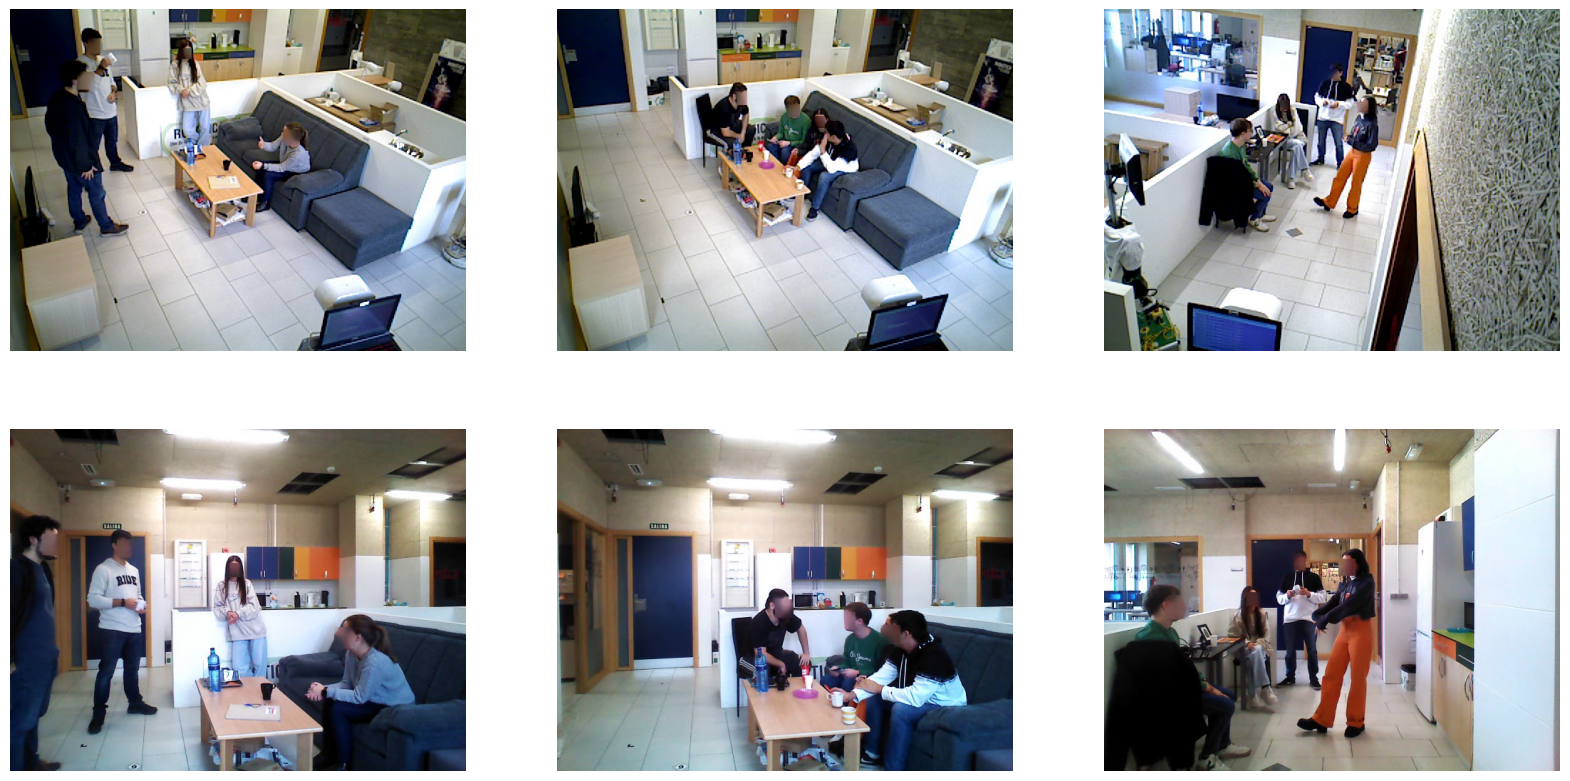

In [86]:
fig, axs = plt.subplots(2,3, figsize=(20,10))


for view, w in zip(['corner', 'tiago'],range(2)):
    for v in range(1,4):
        v_name = 'output_'+view+'_'+str(v)
        img = videos_imgs[v_name][250]
        results = model.predict([img], verbose=False, classes=[0])
        boxes = results[0].boxes.xyxy.cpu().numpy().astype(int)
        for box in boxes:
            person_image = img[box[1]:box[3], box[0]:box[2]] 
            results = face_detection.process(person_image)
            if results.detections is not None:
                bbox_p = results.detections[0].location_data.relative_bounding_box
                px0 = int((bbox_p.xmin)*person_image.shape[1]) + box[0]
                px1 = int((bbox_p.xmin + bbox_p.width)*person_image.shape[1]) + box[0]
                py0 = int((bbox_p.ymin)*person_image.shape[0]) + box[1]
                py1 = int((bbox_p.ymin + bbox_p.height)*person_image.shape[0]) + box[1]
                #print(bbox_p, box, (center_px, center_py), (center_x, center_y), size)
                img[py0:py1, px0:px1] = cv2.medianBlur(img[py0:py1, px0:px1], 25)
        axs[w][v-1].imshow((img))
        axs[w][v-1].axis('off')
        
plt.show()

In [78]:
bbox_p

xmin: 0.3975161910057068
ymin: 0.06624588370323181
width: 0.20711886882781982
height: 0.10103918612003326

In [4]:
colors = [(255,0,0), (255, 128, 0), (255, 153, 255), (127,127,127), (255,255,0), (49, 73,151), (255,127,127)]

def process_video(v_name, images):

    n = int(len(images))

    # instantiate the bar
    f = IntProgress(min=0, max=n) 
    display(f)

    f_users = IntProgress(min=0, max=10) 
    display(f_users)

    users= {}

    video = cv2.VideoWriter('VIDEOS/track/'+'track_'+v_name, 0, 15, (images[0].shape[1], images[0].shape[0]))

    tracker = CentroidTracker() #https://adipandas.github.io/multi-object-tracker/includeme/readmefile.html#example-yolov3-centroidtracker
    tracker.max_lost = 300 #(15*20s)

    for image,i in zip(images[:n], range(n)):    
        image_d = image.copy()
        try:
            detection_bboxes, p_prob = get_users(image_d, 0.9, 0.5)

            #frame, id, bb_left, bb_top, bb_width, bb_height, confidence, x, y, z = track
            output_tracks = tracker.update(detection_bboxes, p_prob, np.ones(p_prob.shape))
            #print(output_tracks)
            for track in output_tracks:
                id_user = track[1]
                bb_left, bb_top, bb_width, bb_height = [ int(t) for t in track[2:6]]
                image_d = cv2.rectangle(image_d, (bb_left, bb_top), (bb_left + bb_width, bb_top + bb_height), colors[id_user], 2)    
                image_d = cv2.putText(image_d, 'UID: '+str(id_user+1), (bb_left, bb_top-10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, colors[id_user], 1, cv2.LINE_AA)

                person_image = image[bb_top:bb_top + bb_height, bb_left:bb_left + bb_width]
                hands = detect_hands(person_image)


                if id_user not in users:
                    users[id_user] = {'left_sign': [], 'right_sign': [], #'left_hands': [], 'right_hands': [],
                                      'left_prob': [], 'right_prob': [], 'left_frame': [], 'right_frame': []}
                #users[id_user]['left_hands'].append(hands['Left'])
                #users[id_user]['right_hands'].append(hands['Right'])


                if hands['Left'] is not None:            
                    left_pred = model([np.append(hands['Left'],[1], axis=0)]).numpy()
                    left_class = (left_pred.argmax(axis=-1) + 1)[0]
                    left_prob = (left_pred.max(axis=-1))[0]

                    users[id_user]['left_sign'].append([left_class])
                    users[id_user]['left_prob'].append([left_prob])
                    users[id_user]['left_frame'].append([track[0]])

                else:
                    users[id_user]['left_sign'].append([0])
                    users[id_user]['left_prob'].append([0])
                    users[id_user]['left_frame'].append([track[0]])

                if hands['Right'] is not None:
                    right_pred = model([np.append(hands['Right'],[0], axis=0)]).numpy()
                    right_class = (right_pred.argmax(axis=-1) + 1)[0]
                    right_prob = (right_pred.max(axis=-1))[0]

                    users[id_user]['right_sign'].append([right_class])        
                    users[id_user]['right_prob'].append([right_prob])        
                    users[id_user]['right_frame'].append([track[0]])    
                else:
                    users[id_user]['right_sign'].append([0])        
                    users[id_user]['right_prob'].append([0])        
                    users[id_user]['right_frame'].append([track[0]])  

            image_d = cv2.putText(image_d, 'FRAME: '+str(track[0]), (20,20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1, cv2.LINE_AA)
            video.write(cv2.cvtColor(image_d, cv2.COLOR_BGR2RGB)) 
        except error:
            print(error)
        f.value += 1 
        f_users.value = len(output_tracks)
        f_users.description = str(len(output_tracks)) +' / '+str(len(users))

    video.release()

    for uid in users:
        for hand in ['left', 'right']:
            df = pd.DataFrame(
                np.concatenate((users[uid][hand+'_frame'], users[uid][hand+'_sign'], users[uid][hand+'_prob']), axis = 1), 
                columns=['frame', 'sign', 'prob'])

            df['frame'] = df['frame'].astype(np.int32)
            df['sign'] = df['sign'].astype(np.int32)

            df.to_csv('VIDEOS/track/'+v_name[:-4]+'_'+str(uid)+'_'+hand+'.csv')

In [5]:
for v_name in videos:

    cap = cv2.VideoCapture('VIDEOS/'+v_name)
    images = []
    
    while cap.isOpened():
        ret, frame = cap.read()
        # if frame is read correctly ret is True
        if not ret:
            break
        #frame = cv2.flip(frame, 1) # Mirror image
        images.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        
        #if len(images)>200:
            #break
        
    cap.release()
    
    print(v_name, len(images))
    
    process_video(v_name, images)

output_corner_1.avi 3065


IntProgress(value=0, max=3065)

IntProgress(value=0, max=10)

output_corner_2.avi 3236


IntProgress(value=0, max=3236)

IntProgress(value=0, max=10)

output_corner_3.avi 3402


IntProgress(value=0, max=3402)

IntProgress(value=0, max=10)

output_tiago_1.avi 1422


IntProgress(value=0, max=1422)

IntProgress(value=0, max=10)

output_tiago_2.avi 1539


IntProgress(value=0, max=1539)

IntProgress(value=0, max=10)

output_tiago_3.avi 1561


IntProgress(value=0, max=1561)

IntProgress(value=0, max=10)

In [ ]:
from detector import zoom_people, get_face, non_max_suppression_fast

import mediapipe as mp

mp_holistic = mp.solutions.holistic
holistic = mp_holistic.Holistic(static_image_mode=True, model_complexity=2, enable_segmentation=True, refine_face_landmarks=True, min_detection_confidence=0.2)

In [ ]:
zoom_images, zoom_positions, zoom_prob, zoom_faces = zoom_people(images[195], positions=True, prob=0.5)
zoom_images = np.array(zoom_images)
zoom_positions = np.array(zoom_positions)
zoom_prob = np.array(zoom_prob)
zoom_faces = np.array(zoom_faces)

#print('ALL: ',zoom_positions.shape)
selected_ids = non_max_suppression_fast(zoom_faces, zoom_prob, overlapThresh=0.7)

In [ ]:
selected_ids, zoom_faces, zoom_positions, zoom_prob

In [ ]:
fig, axs = plt.subplots(1,len(zoom_images), figsize=(20,10))

i= 0
for image in zoom_images:
    axs[i].imshow(image)
    axs[i].axis('off')
    i +=1
plt.show()

In [ ]:
zoom_faces, face_index

In [ ]:
face = get_face(zoom_images[3])

In [ ]:
face

In [ ]:
image_d = images[0].copy()
detection_bboxes, p_prob = get_users(image_d, 0.3, 0.5)

#frame, id, bb_left, bb_top, bb_width, bb_height, confidence, x, y, z = track
output_tracks = tracker.update(detection_bboxes, p_prob, np.ones(p_prob.shape))
#print(output_tracks)
for track in output_tracks:
    id_user = track[1]
    bb_left, bb_top, bb_width, bb_height = [ int(t) for t in track[2:6]]
    image_d = cv2.rectangle(image_d, (bb_left, bb_top), (bb_left + bb_width, bb_top + bb_height), colors[id_user], 2)    
    image_d = cv2.putText(image_d, 'UID: '+str(id_user+1), (bb_left, bb_top-10), cv2.FONT_HERSHEY_SIMPLEX, 0.2, colors[id_user], 1, cv2.LINE_AA)

    person_image = image[bb_top:bb_top + bb_height, bb_left:bb_left + bb_width]
    hands = detect_hands(person_image)
    
plt.imshow(image_d)

In [ ]:
detection_bboxes, p_prob = get_users(images[0], 0.3, 0.5)

In [ ]:
detection_bboxes, zoom_prob = get_users(images[740])

In [ ]:
detection_bboxes, zoom_prob

In [ ]:
hand = 'right'



df_filter = df.copy()
df_filter['sign'] = np.where(df['prob']>0.7, df['sign'], 0)
df_filter.head(50)

In [ ]:
df_fill = fill_holes(df_filter)

In [ ]:
df_filter.shape, df_fill.shape

In [ ]:
colors= ['white','gray', 'navy','gold', 'green', 'blue', 'red', 'orange']
markers = ['o', '8','<', '>', 'p', '*', '^', 'v']
sign_labels = ['S'+str(i) for i in range(1,8) ]

custom_lines = [Line2D([0], [0], color=color, lw=0, marker=marker, markersize=10) for color,marker in zip(colors[1:],markers[1:])]

In [ ]:
frames, signs, classes = get_events([df_filter])
frames2, signs2, classes2 = get_events([df_fill])

In [ ]:
fontsize=10

fig, axs = plt.subplots(3,1, figsize=(15,6),gridspec_kw={'height_ratios': [3,3,1]})

axs[0].set_title('Signs Detected',fontsize=fontsize)

data = get_timeseries_prob(df)
for i in range(7):
    axs[0].plot(data[i], label='S'+str(i), color=colors[i+1], linewidth=2)
axs[0].set_xlabel('Frame', fontsize=fontsize-2)
axs[0].plot([0,max(frames2[0])], [0.7,0.7], color='black', linestyle = '--', linewidth=0.5)
axs[0].set_yticks([0,0.7,1])
axs[0].set_yticklabels([0,0.7,1], fontsize=fontsize)
axs[0].set_ylabel('Probabily', fontsize=fontsize, rotation=0, labelpad=40)

axs[1].set_title('Filtered Signs Detected',fontsize=fontsize)
axs[1].eventplot([frames2[0], frames[0]], colors=[classes2[0], classes[0]], linewidth=10, linelengths=0.5)
axs[1].set_yticks(range(2))
axs[1].set_yticklabels(['Filling Holes', 'Real Detections'], fontsize=fontsize)
axs[1].set_xticks(np.arange(0,max(frames2[0])+4,5))
axs[1].set_xticklabels(np.arange(0,max(frames2[0])+4,5), fontsize=fontsize)
axs[1].set_xlabel('Frame', fontsize=fontsize-2)

axs[0].sharex(axs[1])
axs[0].set_xticklabels(np.arange(0,max(frames2[0])+4,5), fontsize=fontsize)

plt.show()